<a href="https://colab.research.google.com/github/vindhya1103/GenAI/blob/main/GAI_Exp4_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Experiment 4**

Implement an image classification task using pre-trained models like VGGNet, InceptionNet and ResNet and compare the results.

# Description

complete description

# Program

In [6]:
import keras
import numpy as np
from keras import Input
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model
from keras import applications
# from keras import backend as k
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from keras.layers import  Dense, Flatten, Conv2D, MaxPooling2D
# from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

#**Loading the Training and Testing Data and Defining the Basic Parameters**
* About data: https://data.mendeley.com/datasets/tywbtsjrjv/1

Download this data: https://drive.google.com/drive/folders/131DwMyAkwR_F4A_XFQdsaDYXuXF5m4pr?usp=sharing

* We are resizing the input image to 128 * 128

* In the dataset :
    Training Set : 70%
    Validation Set : 20%
    Test Set : 10%

In [7]:
!unzip "plant_village.zip" -d "plant_village"

Archive:  plant_village.zip
   creating: plant_village/plant_village/
   creating: plant_village/plant_village/test/
   creating: plant_village/plant_village/test/Apple_Frogeye_Spot/
  inflating: plant_village/plant_village/test/Apple_Frogeye_Spot/4231e86c-5f4c-439c-be0f-1fa0274581c6___JR_FrgE.S 3067(1).JPG  
  inflating: plant_village/plant_village/test/Apple_Frogeye_Spot/4231e86c-5f4c-439c-be0f-1fa0274581c6___JR_FrgE.S 3067.JPG  
  inflating: plant_village/plant_village/test/Apple_Frogeye_Spot/5435d1b3-2138-47ca-aca4-23cac9d1bb43___JR_FrgE.S 2779(1).JPG  
  inflating: plant_village/plant_village/test/Apple_Frogeye_Spot/5435d1b3-2138-47ca-aca4-23cac9d1bb43___JR_FrgE.S 2779.JPG  
  inflating: plant_village/plant_village/test/Apple_Frogeye_Spot/717c4f62-f05f-4345-a5d7-3b34f3a2efb6___JR_FrgE.S 2836(1).JPG  
  inflating: plant_village/plant_village/test/Apple_Frogeye_Spot/717c4f62-f05f-4345-a5d7-3b34f3a2efb6___JR_FrgE.S 2836.JPG  
  inflating: plant_village/plant_village/test/Apple_Frogey

In [8]:
# Normalize training and validation data in the range of 0 to 1
train_datagen = ImageDataGenerator(rescale=1/255) # vertical_flip=True,
                                                   # horizontal_flip=True,
                                                   # height_shift_range=0.1,
                                                   # width_shift_range=0.1
validation_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# Read the training sample and set the batch size
train_generator = train_datagen.flow_from_directory(
        'plant_village/plant_village/train/',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical')

# Read Validation data from directory and define target size with batch size
validation_generator = validation_datagen.flow_from_directory(
        'plant_village/plant_village/val/',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        'plant_village/plant_village/test/',
        target_size=(128, 128),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)


Found 3033 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
Found 566 images belonging to 4 classes.


# **Visualization of Few Images**

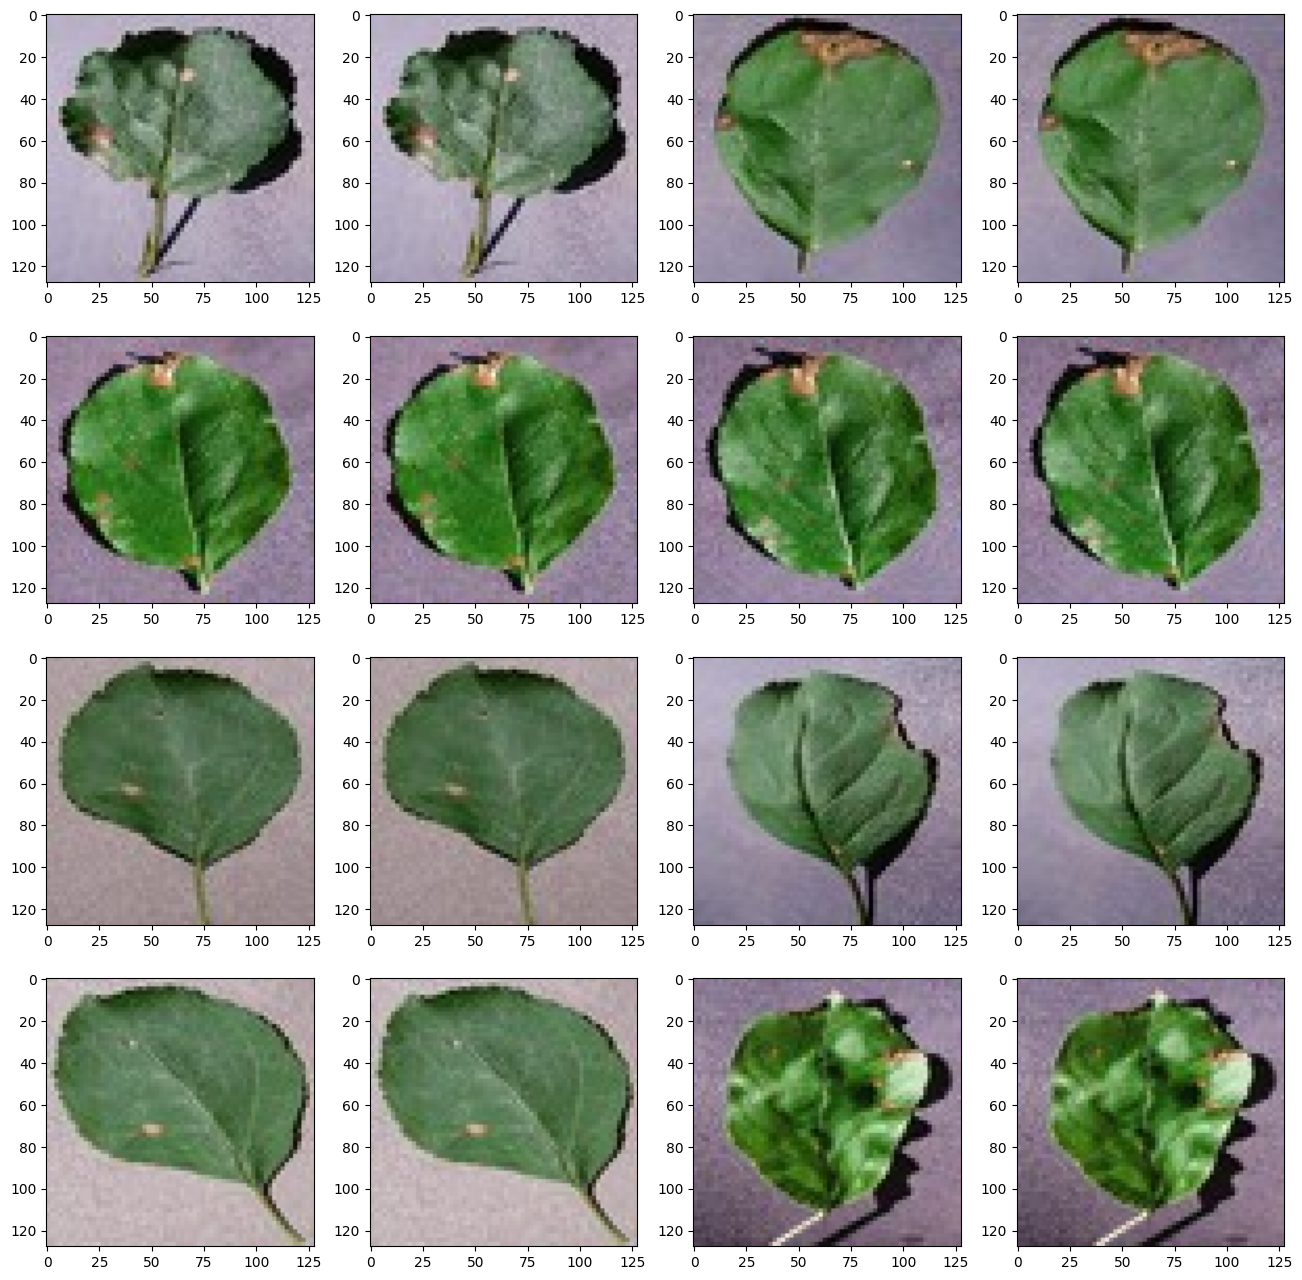

In [9]:
plt.figure(figsize=(16, 16))
for i in range(1, 17):
  plt.subplot(4, 4, i)
  img, label = test_generator.next()
  # print(img.shape)
  # print(label)
  plt.imshow(img[0])
plt.show()

In [10]:
img, label = test_generator.next()
img[0].shape

(128, 128, 3)

#**What is ImageNet?**
ImageNet is formally a project aimed at (manually) labeling and categorizing images into almost 22,000 separate object categories for the purpose of computer vision research.

However, when we hear the term “ImageNet” in the context of deep learning and Convolutional Neural Networks, we are likely referring to the ImageNet Large Scale Visual Recognition Challenge, or ILSVRC for short.

The goal of this image classification challenge is to train a model that can correctly classify an input image into 1,000 separate object categories.

Models are trained on ~1.2 million training images with another 50,000 images for validation and 100,000 images for testing.

# **Exploring Keras Applications for Transfer Learning**

## **VGG16**

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape= (128, 128, 3)) # Include_top = False means excluding the model fully connected layers
base_model.trainable = False ## Not trainable weights

base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

# **Adding top layers according to number of classes in our data**

In [12]:
flatten_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(4, activation='softmax')

model = models.Sequential([
    base_model,
    flatten_layer,
    prediction_layer
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 14716740 (56.14 MB)
Trainable params: 2052 (8.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# **Training**

In [13]:
# We are going to use accuracy metrics and cross entropy loss as performance parameters
model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = model.fit(train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1)

Epoch 1/30
189/189 [==============================] - 13s 45ms/step - loss: 0.9836 - acc: 0.6116 - val_loss: 0.7406 - val_acc: 0.8031
Epoch 2/30
189/189 [==============================] - 5s 29ms/step - loss: 0.6470 - acc: 0.8084 - val_loss: 0.5301 - val_acc: 0.8598
Epoch 3/30
189/189 [==============================] - 5s 27ms/step - loss: 0.5000 - acc: 0.8609 - val_loss: 0.4279 - val_acc: 0.8976
Epoch 4/30
189/189 [==============================] - 5s 28ms/step - loss: 0.4155 - acc: 0.8945 - val_loss: 0.3737 - val_acc: 0.9071
Epoch 5/30
189/189 [==============================] - 5s 27ms/step - loss: 0.3632 - acc: 0.9017 - val_loss: 0.3319 - val_acc: 0.9260
Epoch 6/30
189/189 [==============================] - 5s 28ms/step - loss: 0.3265 - acc: 0.9146 - val_loss: 0.3004 - val_acc: 0.9276
Epoch 7/30
189/189 [==============================] - 5s 28ms/step - loss: 0.2975 - acc: 0.9202 - val_loss: 0.2744 - val_acc: 0.9339
Epoch 8/30
189/189 [==============================] - 5s 28ms/step -

# **Saving the model**

In [14]:
model.save("VGG16_plant_deseas.h5")
print("Saved model to disk")

Saved model to disk


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Loading the model**

In [15]:
model = models.load_model('VGG16_plant_deseas.h5')
print("Model is loaded")

Model is loaded


# **Visualization of training over epoch**

In [16]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

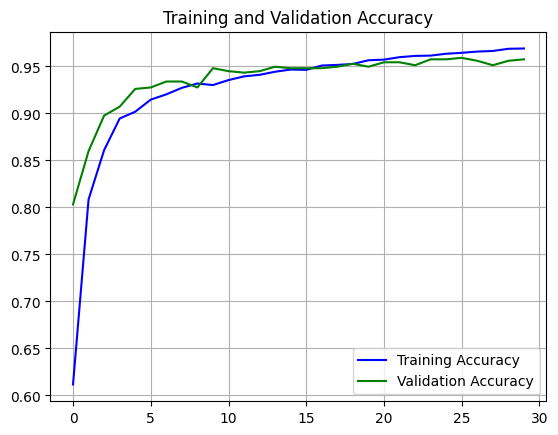

<Figure size 640x480 with 0 Axes>

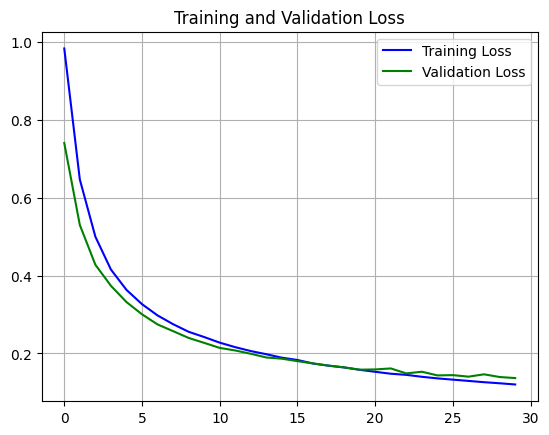

In [17]:
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

# **Performance measure**

In [18]:
# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))


<ipython-input-18-817e596488b3>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)


566/566 [==============================] - 4s 6ms/step
No of errors = 35/566


In [19]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

93.81625441696113

In [20]:
!pip install seaborn

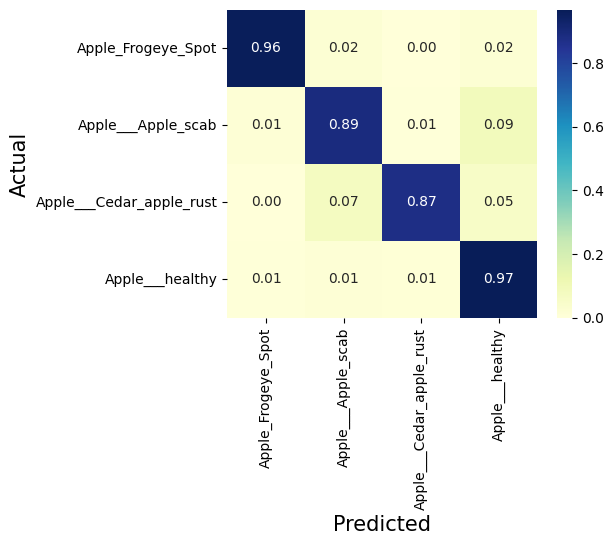

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.96      0.96      0.96       103
      Apple___Apple_scab       0.92      0.89      0.90       134
Apple___Cedar_apple_rust       0.92      0.87      0.90        55
         Apple___healthy       0.94      0.97      0.95       274

                accuracy                           0.94       566
               macro avg       0.94      0.92      0.93       566
            weighted avg       0.94      0.94      0.94       566



# **InceptionNet**

In [23]:
from keras import applications

## Loading InceptionV3 model
base_model = applications.InceptionV3(weights="imagenet", include_top=False, input_shape= (128, 128, 3))
base_model.trainable = False ## Not trainable weights

base_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 63, 63, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 63, 63, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [26]:
# include GlobalAveragePooling2D
flatten_layer = layers.GlobalAveragePooling2D()
# include final Dense layer
prediction_layer = layers.Dense(4, activation='softmax')
model = models.Sequential([base_model, flatten_layer, prediction_layer])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 21810980 (83.20 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [28]:
# Compile model with Adam Optimizer (learning_rate = 0.001), categorical_crossentropy loss, accuracy metric
model.compile(optimizer 	= 	Adam(learning_rate 	= 	0.001), loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(train_generator, steps_per_epoch=train_generator.samples/train_generator.batch_size, epochs=30, validation_data=validation_generator,
validation_steps=validation_generator.samples/validation_generator.batch_size, verbose=1)

Epoch 1/30
189/189 [==============================] - 19s 64ms/step - loss: 0.5650 - acc: 0.8042 - val_loss: 0.2881 - val_acc: 0.8945
Epoch 2/30
189/189 [==============================] - 6s 31ms/step - loss: 0.2077 - acc: 0.9331 - val_loss: 0.2522 - val_acc: 0.8913
Epoch 3/30
189/189 [==============================] - 5s 24ms/step - loss: 0.1399 - acc: 0.9558 - val_loss: 0.2920 - val_acc: 0.8945
Epoch 4/30
189/189 [==============================] - 6s 29ms/step - loss: 0.1001 - acc: 0.9716 - val_loss: 0.2101 - val_acc: 0.9307
Epoch 5/30
189/189 [==============================] - 6s 31ms/step - loss: 0.0726 - acc: 0.9829 - val_loss: 0.2245 - val_acc: 0.9102
Epoch 6/30
189/189 [==============================] - 7s 36ms/step - loss: 0.0595 - acc: 0.9875 - val_loss: 0.2356 - val_acc: 0.9071
Epoch 7/30
189/189 [==============================] - 7s 38ms/step - loss: 0.0498 - acc: 0.9908 - val_loss: 0.2970 - val_acc: 0.8976
Epoch 8/30
189/189 [==============================] - 6s 33ms/step -

In [29]:
# Save model
model.save("ResNet50_plant_disease.h5")
print("Saved model to disk")
model = models.load_model('ResNet50_plant_disease.h5')
print("Model is loaded")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk
Model is loaded


In [30]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

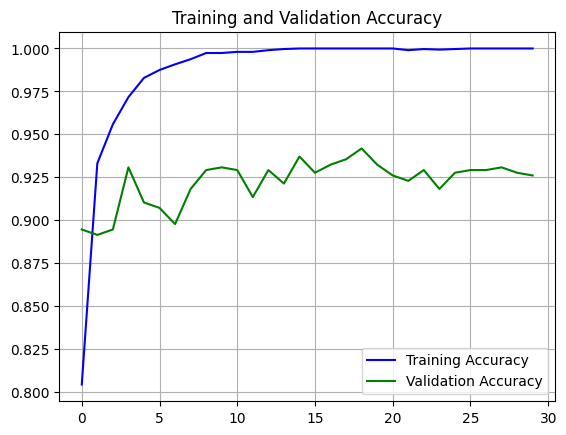

<Figure size 640x480 with 0 Axes>

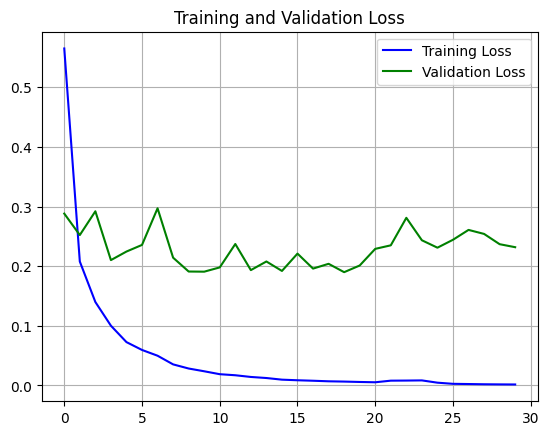

In [31]:
# Display loss/accuracies vs epochs
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [32]:
# Get the filenames from the generator
#fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))


<ipython-input-32-3d2dfb866fa4>:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)


566/566 [==============================] - 9s 11ms/step
No of errors = 50/566


In [33]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

91.16607773851591

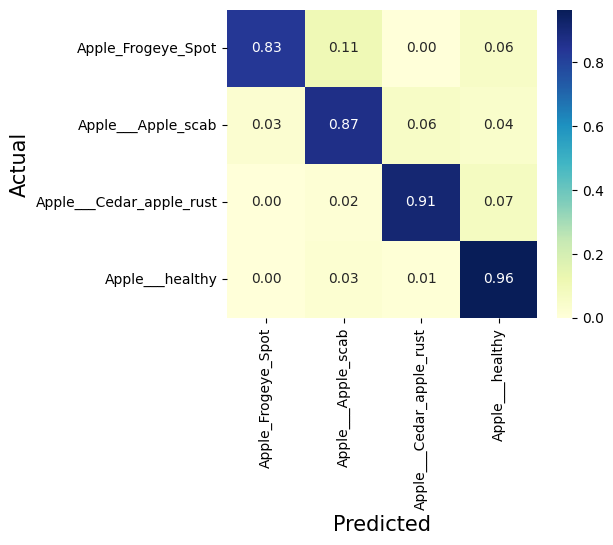

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [35]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.96      0.83      0.89       103
      Apple___Apple_scab       0.86      0.87      0.86       134
Apple___Cedar_apple_rust       0.82      0.91      0.86        55
         Apple___healthy       0.94      0.96      0.95       274

                accuracy                           0.91       566
               macro avg       0.89      0.89      0.89       566
            weighted avg       0.91      0.91      0.91       566



#**ResNet**

In [36]:
from keras import applications

## Loading VGG16 model
base_model = applications.ResNet50(weights="imagenet", include_top=False, input_shape= (128, 128, 3))
base_model.trainable = False ## Not trainable weights

base_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [37]:
# include GlobalAveragePooling2D
flatten_layer = layers.GlobalAveragePooling2D()
# include final Dense layer
prediction_layer = layers.Dense(4, activation='softmax')
model = models.Sequential([base_model, flatten_layer, prediction_layer])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [38]:
# Compile model with Adam Optimizer (learning_rate = 0.001), categorical_crossentropy loss, accuracy metric
model.compile(optimizer 	= 	Adam(learning_rate 	= 	0.001), loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(train_generator, steps_per_epoch=train_generator.samples/train_generator.batch_size,       epochs=30, validation_data=validation_generator,
validation_steps=validation_generator.samples/validation_generator.batch_size, verbose=1)

Epoch 1/30
189/189 [==============================] - 13s 43ms/step - loss: 1.2816 - acc: 0.4349 - val_loss: 1.1877 - val_acc: 0.5181
Epoch 2/30
189/189 [==============================] - 6s 32ms/step - loss: 1.2301 - acc: 0.4629 - val_loss: 1.1718 - val_acc: 0.5181
Epoch 3/30
189/189 [==============================] - 6s 29ms/step - loss: 1.2107 - acc: 0.4632 - val_loss: 1.1599 - val_acc: 0.5181
Epoch 4/30
189/189 [==============================] - 6s 30ms/step - loss: 1.1919 - acc: 0.4639 - val_loss: 1.1283 - val_acc: 0.5228
Epoch 5/30
189/189 [==============================] - 5s 28ms/step - loss: 1.1753 - acc: 0.4675 - val_loss: 1.1131 - val_acc: 0.5181
Epoch 6/30
189/189 [==============================] - 5s 28ms/step - loss: 1.1616 - acc: 0.4708 - val_loss: 1.1161 - val_acc: 0.5496
Epoch 7/30
189/189 [==============================] - 6s 29ms/step - loss: 1.1487 - acc: 0.4797 - val_loss: 1.0761 - val_acc: 0.5276
Epoch 8/30
189/189 [==============================] - 5s 28ms/step -

In [39]:
# Save the model
model.save("ResNet50_plant_disease.h5")
print("Saved model to disk")
model = models.load_model('ResNet50_plant_disease.h5')
print("Model is loaded")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk
Model is loaded


In [40]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

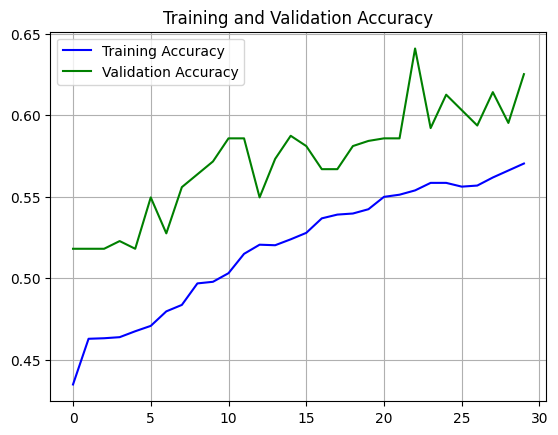

<Figure size 640x480 with 0 Axes>

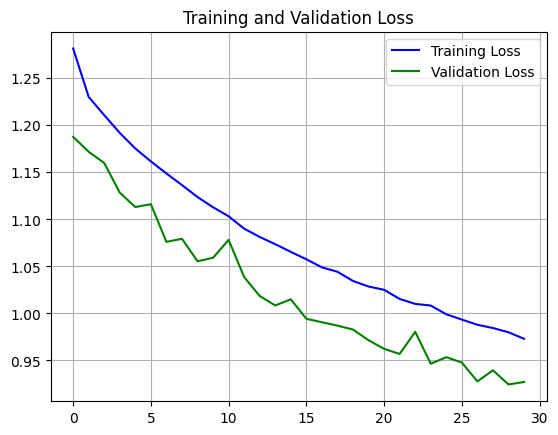

In [42]:
# Display loss/accuracies vs epochs
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [43]:
# Get the filenames from the generator
#fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
#idx2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))


<ipython-input-43-46ff43250d4c>:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)


566/566 [==============================] - 8s 11ms/step
No of errors = 240/566


In [44]:
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

57.59717314487632

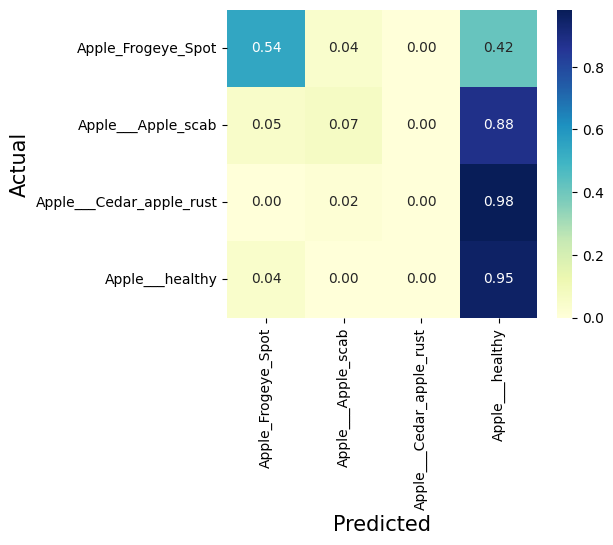

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [46]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

                          precision    recall  f1-score   support

      Apple_Frogeye_Spot       0.75      0.54      0.63       103
      Apple___Apple_scab       0.60      0.07      0.12       134
Apple___Cedar_apple_rust       0.00      0.00      0.00        55
         Apple___healthy       0.55      0.95      0.70       274

                accuracy                           0.58       566
               macro avg       0.47      0.39      0.36       566
            weighted avg       0.54      0.58      0.48       566



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusion
